# 2. MobileNetV2
Our second attempt will be to use a pretrained model MobileNetV2. This model is relatively small compared to others, therefore it may train faster.

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import numpy as np

In [2]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda vesion:', cuda_version)
cudnn_version = sys_details["cudnn_version"]  
print('Cudnn vesion:', cudnn_version)

Cuda vesion: 11.2
Cudnn vesion: 8


## Preparation and model creation
Uncomment the configuration that you would like to train.

Compared to our baseline we will use batch size of 32 images.

In [3]:
_train_dir = 'resized128/train'
_test_dir = 'resized128/test'
_img_width, _img_height = 128,128 
_batch_size = 32
_weights_name = 'maskedfaces128_mobilenetv2.h5'

In [4]:
# _train_dir = 'resized224/train'
# _test_dir = 'resized224/test'
# _img_width, _img_height = 224,224 
# _batch_size = 32
# _weights_name = 'maskedfaces224_mobilenetv2.h5'

Note, that we using a preprocessing function argument, that contains preprocess_input function for MobileNetV2.

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    _train_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    _train_dir, # same directory as training data
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 96658 images belonging to 2 classes.
Found 17057 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) 

test_generator = train_datagen.flow_from_directory(
    _test_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary')

Found 20067 images belonging to 2 classes.


In this model we are adding a MobileNetV2 model pretrained on the imagenet dataset. We are also not allowing to MobileNetV2 to learn further. We will not do any other changes just add average pooling layer and ouput dense layer. We are using Adam optimizer with 0.01 learning rate and accuracy metric.

In [7]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(_img_width, _img_height, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01),  metrics=['accuracy'])
model.summary()

2021-12-29 14:17:53.812195: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 14:17:54.334566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9716 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model
We have also added a checkpoint save weights with the best validation loss. You can also [skip](#skip) the training.

In [8]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

We will train the model for 10 epochs.

In [9]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs=10, callbacks=[checkpointer], verbose=True)

Epoch 1/10


2021-12-29 14:18:02.567795: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


3021/3021 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.5830
Epoch 00001: val_loss improved from inf to 0.59585, saving model to maskedfaces128_mobilenetv2.h5


/home/rbelanec/Documents/ml-project/ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3021/3021 [==============================] - 458s 151ms/step - loss: 0.6738 - accuracy: 0.5830 - val_loss: 0.5958 - val_accuracy: 0.7327
Epoch 2/10
3021/3021 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.6713
Epoch 00002: val_loss improved from 0.59585 to 0.54435, saving model to maskedfaces128_mobilenetv2.h5
3021/3021 [==============================] - 423s 140ms/step - loss: 0.6051 - accuracy: 0.6713 - val_loss: 0.5444 - val_accuracy: 0.7765
Epoch 3/10
3021/3021 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.7147
Epoch 00003: val_loss improved from 0.54435 to 0.51512, saving model to maskedfaces128_mobilenetv2.h5
3021/3021 [==============================] - 423s 140ms/step - loss: 0.5630 - accuracy: 0.7147 - val_loss: 0.5151 - val_accuracy: 0.7872
Epoch 4/10
3021/3021 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.7469
Epoch 00004: val_loss improved from 0.51512 to 0.48600, saving model to maskedfaces128_mobi

Now we will plot the training history and evaluate our model on test data.

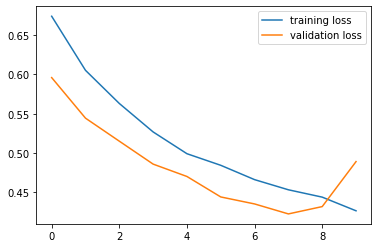

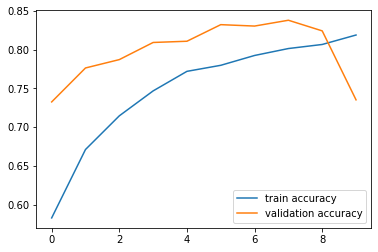

In [10]:
plt.figure()
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

<a id='skip'></a> If you want to skip the training, just uncomment the first or the second cell under this text. But don't forget to recompile the model with desired (128/224) configuration.

In [11]:
# wget
# _weights_name = 'maskedfaces128_mobilenetv2.h5'

In [12]:
# wget
# _weights_name = 'maskedfaces128_mobilenetv2.h5'

In [13]:
model.load_weights(_weights_name)

In [14]:
train_score = model.evaluate(train_generator)
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test_generator)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

3021/3021 [==============================] - 359s 119ms/step - loss: 0.4155 - accuracy: 0.8457


train loss: 0.4154919385910034 | train acc: 0.8456827402114868

628/628 [==============================] - 81s 129ms/step - loss: 0.4120 - accuracy: 0.8486


test loss: 0.4120059013366699 | test acc: 0.8486071825027466


In [15]:
model_predictions = model.predict(test_generator)

In [16]:
preds = np.array(model_predictions > 0.5).astype(int).T[0]
labels = np.array(test_generator.classes)

f1 = f1_score(labels, preds)
print('F1 score: ', f1)

F1 score:  0.5063466878222929


## Conclusion

Our model with pretrained MobileNetV2 model with disabled learning ended up with much better accuracy, but if look at the F1 score it's still bad. We think we can go further and experiment with other pretrained nets or add more layers after the pretrained net. We will continue in next notebook (TODO link). The training of this model was around 6 minutes per epoch on 128x128 images and around 16 minutes per epoch on 224x224 images.

### 224x224 images
Our MobileNetV2 model with 224x224 images ended up with results:
- train loss: 0.29
- train accuracy: 0.89
- test loss: 0.29
- test accuracy: 0.89
- F1 score: 0.51

### 128x128 images
Our MobileNetV2 model with 128x128 images ended up with results:
- train loss: 0.42
- train accuracy: 0.85
- test loss: 0.41
- test accuracy: 0.85
- F1 score: 0.51